#Нейросеть для определения тональности отзывов

С помощью модуля pandas загружаем датасет с отзывами из csv файла и фильтруем ненужные значение (Удаляем строки с "нейтральными" отзывами)

In [54]:
import pandas as pd

df = pd.read_csv('women-clothing-accessories.3-class.balanced.csv', sep='\t')
df.columns = ['review', 'sentiment']
print(len(df))

df = df[(df.sentiment != 'neautral')]

print(len(df))

data_x = df.iloc[0:,0]
data_y = df.iloc[0:,1]

data_y = data_y.map({'positive': 1, 'negative': 0})

90000
60000


Производим токенизацию всех слов, после чего получаем максимальную длину отзыва и количество слов

In [55]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_x)
data_sequence = tokenizer.texts_to_sequences(data_x)

max_len = max([len(s) for s in data_sequence])

vocab_size = len(tokenizer.word_index) + 1

Конвертируем отзывы в массивы из токенов. Если отзыв короче максимального вставляем нули справа (padding='post')

In [56]:
from keras.utils import pad_sequences

# Pad the training sequences
data_padded = pad_sequences(data_sequence, padding='post')


Разделяем данные на тренировочные и тестовые

In [57]:
train_x = data_padded[0:55000]
train_y = data_y[0:55000]

test_x = data_padded[55000:]
test_y = data_y[55000:]

Создаем саму модель. Добавляем 4 сверточных слоя, с каждым слоем уменьшая количество нейронов в два раза. Также применяем дропаут, чтобы исключить переобучение сети.

In [58]:
import keras
from keras.models import Sequential
from keras.layers import Dense , Dropout , Activation, Embedding
from keras.layers import MaxPooling1D , GlobalMaxPooling1D,Conv1D , Flatten

model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = max_len))
model.add(Conv1D(256, kernel_size=5, activation='relu'))
model.add(Dropout(0.75))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(Dropout(0.75))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(Dropout(0.75))
model.add(Conv1D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')

Тренируем модель и выводим результаты тренировки на графике. Проводим 4 итерации, перед каждой итерацией перемешиваем данные. Также испольуем 5% данных для валидации

Epoch 1/4
409/409 [==============================] - 91s 222ms/step - loss: 0.4259 - accuracy: 0.7967 - val_loss: 0.1925 - val_accuracy: 0.9625
Epoch 2/4
409/409 [==============================] - 99s 241ms/step - loss: 0.2107 - accuracy: 0.9263 - val_loss: 0.1453 - val_accuracy: 0.9622
Epoch 3/4
409/409 [==============================] - 102s 249ms/step - loss: 0.1561 - accuracy: 0.9468 - val_loss: 0.1730 - val_accuracy: 0.9469
Epoch 4/4
409/409 [==============================] - 105s 257ms/step - loss: 0.1249 - accuracy: 0.9594 - val_loss: 0.1618 - val_accuracy: 0.9535


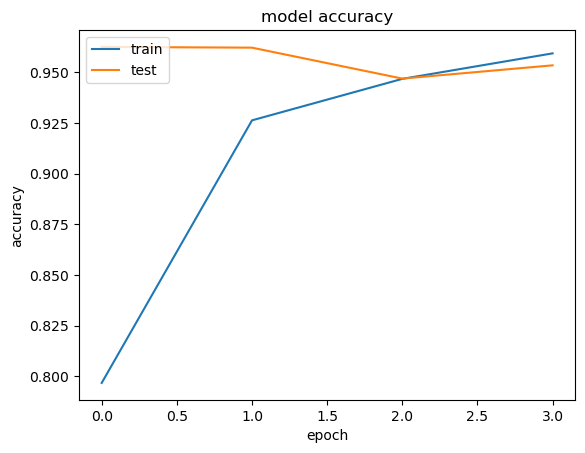

In [59]:
history = model.fit(train_x, train_y, epochs=4, batch_size=128, verbose=1, validation_split=0.05, shuffle=True)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Проверяем модель на тестовых данных

In [26]:
scores = model.evaluate(test_x, test_y, verbose=1)
scores

157/157 [==============================] - 1s 9ms/step - loss: 0.2354 - accuracy: 0.9492


[0.2354479730129242, 0.9491999745368958]

Чтение ввода от пользователя и предсказывание

In [53]:
user_review = input('Введите ваш отзыв')

user_sequence = tokenizer.texts_to_sequences([user_review])
user_padded = pad_sequences(user_sequence, padding='post', maxlen=max_len)

pred = model.predict(user_padded)[0][0]
print("Вероятность того, что отзыв положительный:  {:.2f}%".format(pred * 100))
# print(f"Вероятность того, что отзыв положительный: {pred * 100}")

Введите ваш отзывПродукт имеет запах, и материал не из хлопка выглядит как нейлон. Это не то, что я ожидал, что я не смогу использовать его.
1/1 [==============================] - 0s 19ms/step
Вероятность того, что отзыв положительный:  6.09%
